<a href="https://colab.research.google.com/github/Kridge42/Metabolic-Syndrome/blob/main/Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predicting Metabolic Syndrome


#####Kevin Ridge

This data comes from the National Center for Statistics.

- link to data.world source: https://data.world/informatics-edu/metabolic-syndrome-prediction

In [1]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, \
ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [4]:
# Load data and display frame
path = '/content/drive/MyDrive/Data/Metabolic  Syndrome.csv'
df = pd.read_csv(path)
df.head()

,seqn,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
0,62161,22,Male,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,No MetSyn
1,62164,44,Female,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,No MetSyn
2,62169,21,Male,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,No MetSyn
3,62172,43,Female,Single,2000.0,Black,120.4,33.3,0,5.22,5.0,104,73,141,No MetSyn
4,62177,51,Male,Married,NaN,Asian,81.1,20.1,0,8.13,5.0,95,43,126,No MetSyn


##**Inspecting data**

In [5]:
# Display basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2401 entries, 0 to 2400
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   seqn               2401 non-null   int64  
 1   Age                2401 non-null   int64  
 2   Sex                2401 non-null   object 
 3   Marital            2193 non-null   object 
 4   Income             2284 non-null   float64
 5   Race               2401 non-null   object 
 6   WaistCirc          2316 non-null   float64
 7   BMI                2375 non-null   float64
 8   Albuminuria        2401 non-null   int64  
 9   UrAlbCr            2401 non-null   float64
 10  UricAcid           2401 non-null   float64
 11  BloodGlucose       2401 non-null   int64  
 12  HDL                2401 non-null   int64  
 13  Triglycerides      2401 non-null   int64  
 14  MetabolicSyndrome  2401 non-null   object 
dtypes: float64(5), int64(6), object(4)
memory usage: 281.5+ KB


- There are missing values in Marital, Income, WaistCirc, and BMI Columns.

In [6]:
# Display the number of rows and columns
df.shape
print(f'There are {df.shape[0]} rows, and {df.shape[1]} columns.')

There are 2401 rows, and 15 columns.


In [7]:
# Check numerical columns
df.describe()

,seqn,Age,Income,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides
count,2401.000000,2401.000000,2284.000000,2316.000000,2375.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000
mean,67030.674302,48.691795,4005.253940,98.307254,28.702189,0.154102,43.626131,5.489046,108.247813,53.369429,128.125364
std,2823.565114,17.632852,2954.032186,16.252634,6.662242,0.422780,258.272829,1.439358,34.820657,15.185537,95.322477
min,62161.000000,20.000000,300.000000,56.200000,13.400000,0.000000,1.400000,1.800000,39.000000,14.000000,26.000000
25%,64591.000000,34.000000,1600.000000,86.675000,24.000000,0.000000,4.450000,4.500000,92.000000,43.000000,75.000000
50%,67059.000000,48.000000,2500.000000,97.000000,27.700000,0.000000,7.070000,5.400000,99.000000,51.000000,103.000000
75%,69495.000000,63.000000,6200.000000,107.625000,32.100000,0.000000,13.690000,6.400000,110.000000,62.000000,150.000000
max,71915.000000,80.000000,9000.000000,176.000000,68.700000,2.000000,5928.000000,11.300000,382.000000,156.000000,1562.000000


- The seqn column appears to be a unique identification number. I will drop this column during the train test split. With so many irrelevant unique values, seqn will not effect model training. 
- WaistCirc has possible outlier of 176.0 cm. I will test between the 75% and max to make sure. 
- Albuinuria has 0.0 for minimum and everthing between to the max. I will have to inspect this column.
- UrAlbCr has a rather high max which might be an outlier.
- 382 for a fasting BloodGlucose is very high. 
- The max in Triglycerides also appears to be an outlier. 
- For now, I will leave the higher numbers in this dataset as possible outliers. I will study further to see if these are realistic numbers. 

In [8]:
# Check the categorical columns
df.describe(include='object')

,Sex,Marital,Race,MetabolicSyndrome
count,2401,2193,2401,2401
unique,2,5,6,2
top,Female,Married,White,No MetSyn
freq,1211,1192,933,1579


- No outstanding notes at first glance. 

##**Data Cleaning**

In [9]:
# Display total number of duplicates
df.duplicated().sum()

0

- No duplicate rows to drop. 

In [10]:
# Display names of categorical columns and create a varible
dtypes = df.dtypes
typ_obj = dtypes[dtypes== 'object'].index
typ_obj

Index(['Sex', 'Marital', 'Race', 'MetabolicSyndrome'], dtype='object')

- No inconsistentcies here.

In [11]:
# Display values for categorical columns
for col in typ_obj:
  print(f'-Column= {col}')
  print(df[col].value_counts(dropna=False))
  print('\n')

-Column= Sex
Female    1211
Male      1190
Name: Sex, dtype: int64


-Column= Marital
Married      1192
Single        498
Divorced      242
NaN           208
Widowed       166
Separated      95
Name: Marital, dtype: int64


-Column= Race
White          933
Black          548
Asian          349
Hispanic       257
MexAmerican    253
Other           61
Name: Race, dtype: int64


-Column= MetabolicSyndrome
No MetSyn    1579
MetSyn        822
Name: MetabolicSyndrome, dtype: int64




- Aside form the NaN entries for Marital, no other inconsistentcies here.

In [12]:
# Find how many measurements are above 135 centimeters for waist circumference
cm = 135
count = (df['WaistCirc'] > cm).sum()
print(f'There are {count} values between 135 cm and the max of 176 cm.')

There are 63 values between 135 cm and the max of 176 cm.


In [13]:
# Find how many measurements are above 150 centimeters for waist circumference
cm2 = 150
count2 = (df['WaistCirc'] > cm2).sum()
print(f'There are {count2} values between 155 cm and the max of 176 cm.')

There are 10 values between 155 cm and the max of 176 cm.


- With this information, I can safely say that 176.0 centimeters is not an outlier. 

In [15]:
# Find out why there are values of 0 in Albuminuria column
df.value_counts('Albuminuria')

Albuminuria
0    2089
1     254
2      58
dtype: int64

- The zero values in the Albuminuria column are fine. 
- Albuminuria is an ordinal feature.
- I will have to research for the ordinal importance for all three choices.

In [17]:
# Display missing values for each feature
print(df.isna().sum())

seqn                   0
Age                    0
Sex                    0
Marital              208
Income               117
Race                   0
WaistCirc             85
BMI                   26
Albuminuria            0
UrAlbCr                0
UricAcid               0
BloodGlucose           0
HDL                    0
Triglycerides          0
MetabolicSyndrome      0
dtype: int64


- Adressing the missing data:
 - I will not drop any row nor column, this would lead to data loss. 
 - All imputations for missing values will take place after the train and test data split to prevent data leakage. 
 - Marital can be filled with "unknown" for missing values. With five possible choices, I don't want to create correlations by imputing 208 values with one of those choices.
 - Income will be filled with the median strategy.   
 - I could use median or mean strategies for WaistCirc and BMI. However, I feel using either could slightly distort the data. I will inspect further and possibly use "unknown" imputation since the missing values are so few. 

##**Exploratory analyisis**

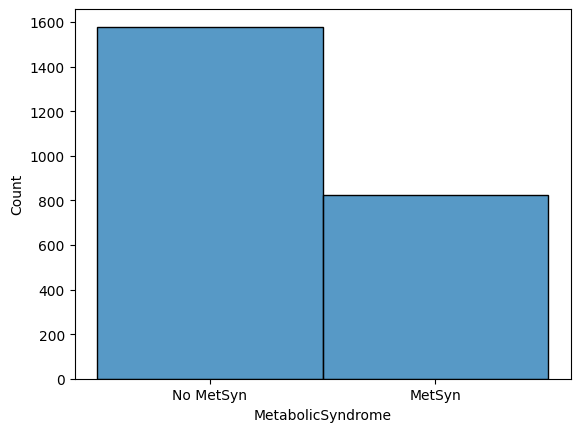

In [47]:
# Univariate plot for MetabolicSyndrome
sns.histplot(df['MetabolicSyndrome']);

- Visual shows the positive and negative counts for MetabolicSyndrome. 

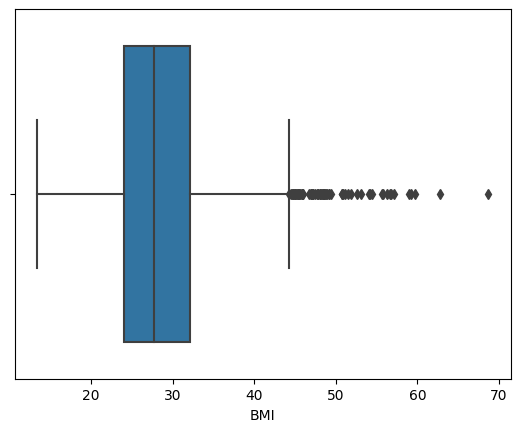

In [53]:
# Boxplot visual for Body Mass Index 
sns.boxplot(x=df['BMI']);

- Most of the participants have between 24 and 33 BMI. 

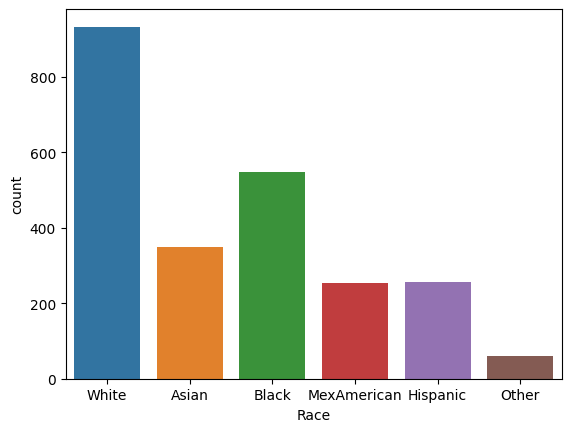

In [82]:
# Visualize what races participated in the study with a countplot
sns.countplot(x=df['Race']);

- Visual shows number of each race participating in this study. Since there is not an even balance of particiants, this data will unlikely link genetic predispositions to develop metabolic syndrome based on race.

### END OF UNIVARIATE PLOTS FOR PART 2. THE FOLLOWING ARE JUST IDEAS TO EXPLORE FOR LATER PRODUCTION.

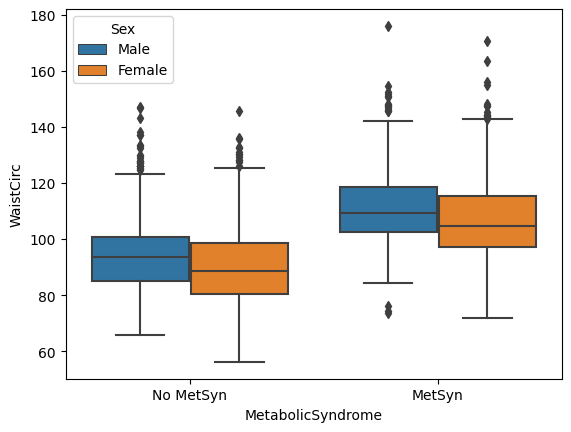

In [58]:
sns.boxplot(data=df, x='MetabolicSyndrome', y='WaistCirc', hue='Sex');

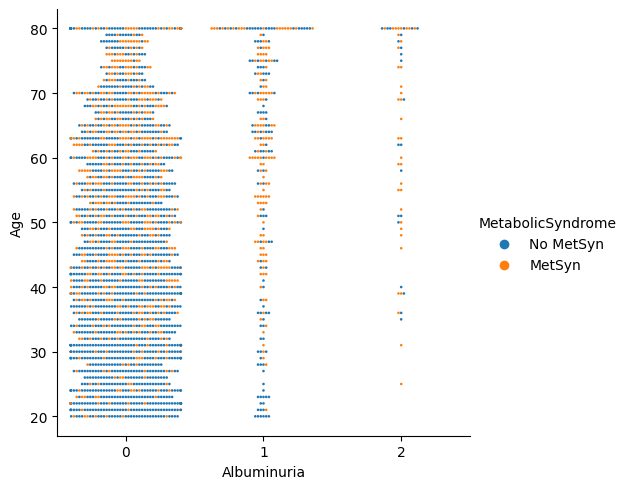

In [24]:
sns.catplot(data=df, x='Albuminuria', y='Age', hue='MetabolicSyndrome', 
            order=df['Albuminuria'].value_counts().index, s= 3.5, kind='swarm');

<ipython-input-43-63b165a56b63>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<Axes: >

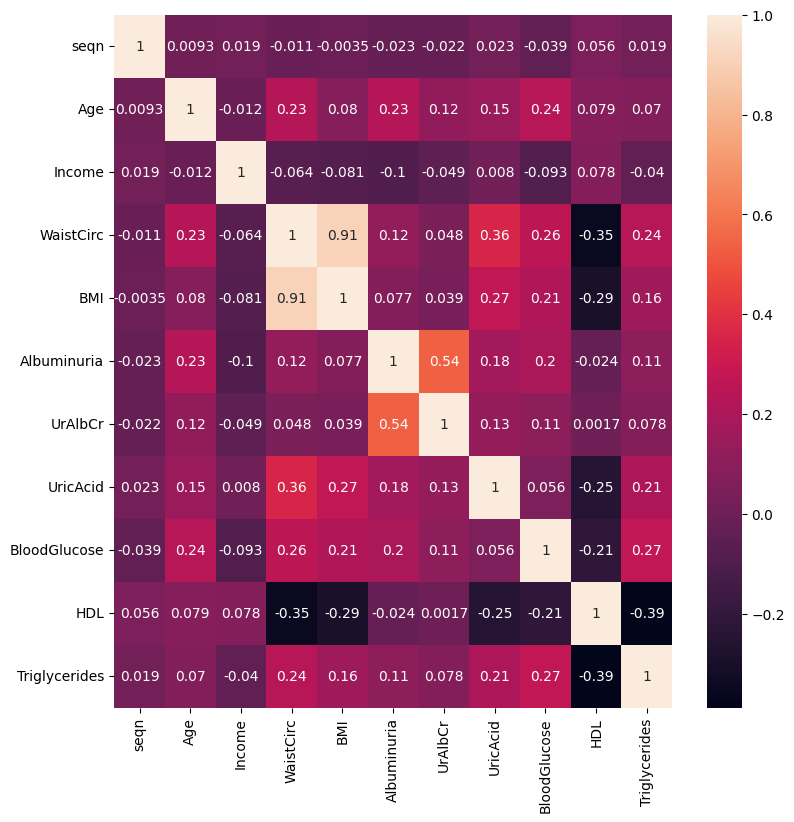

In [43]:
corr = df.corr()
plt.figure(figsize = (9, 9))
sns.heatmap(corr, annot=True)

/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3544: UserWarning: 50.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3544: UserWarning: 46.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3544: UserWarning: 52.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3544: UserWarning: 22.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3544: UserWarning: 50.0% of the points cannot be placed; y

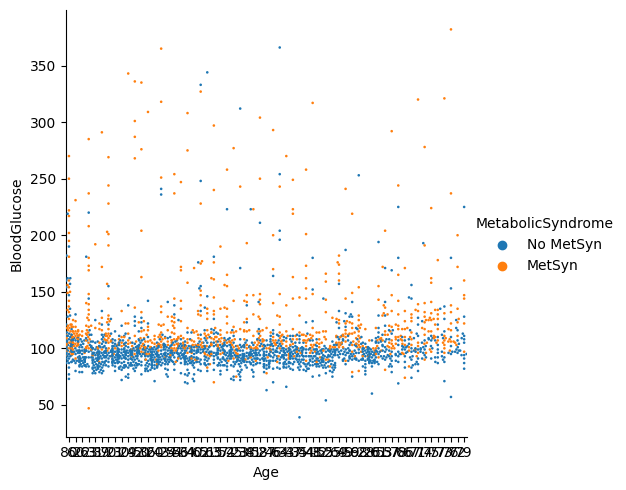

In [45]:
sns.catplot(data=df, x='Age', y='BloodGlucose', hue='MetabolicSyndrome', 
            order=df['Age'].value_counts().index, s= 3.5, kind='swarm')

#### This data is showing the many factors that could be related to developing metabolic syndrome. The main features include: body mass index, waist circumference, triglycerides above 150, HDL cholesterol below 50 in women or 40 in men, established proteinurnia, uric acid levels, and elevated fasting blood sugar (100-125). These columns all represent measurements that qualified medical professionals use to obtain a snapshot of health. I will have to do further research on what the UrAlbCr column represents. Also, it seems to have no history of blood pressure measurements. Age, sex, marital status, income, race are all personal attributes and could play a factor even thought they seem less relevant at first glance. 
#### **The target is metabloic syndrome. It is a classification problem because we are determining whether or not someone does or does not develop said condition.**

#### There are 15 features and 2401 rows in the dataset.

Challenges include: the missing data, why the data set did not feature blood pressure, what is UrAlbCR, and is there a clear link to one or all of these factors for the patients who did develop metabolic syndrome?